# Fitting Survival Data from C. elegans alpha-ketoglutarate treatment

Estimating $f$ and $I$ from survival data of real-world systems to predict corresponding optimal repair protocols

See manuscript for appropriate references

In [1]:
from model import *
import pandas as pd
from q_learning import *

In [2]:
# Function for getting failure times
def get_pop_ftimes (pop_size, N, f, I, r=0):
    # Simulate pop networks (end_time = 150 to match data)
    pop = pop_size
    vits = []
    fail_times = []
    for n in range(pop):
        vit, inter, ftime, cost = simIndividual(N=N, p=0.1, d=0, f=f, r=r, f_thresh=0.01,
            graph_type='Grandom_s', weight_type='uniform', check_type='none', kinetic=1, P_check=1, e=0, cost_type=['healthspan_quadratic', 8000], 
            costC=0.1, costR=1, costE=0.5, costD=0.5, costL=1, P_repl=0, costrepl=1, max_repl=1, repl_type='constant',
            node_type='binary', damage_type='uniform', edge_type='binary', f_edge=0, r_edge=0, std=0.3, 
            P_ablate=0,costablate=1,ablate_type='constant',repair_start=0,repair_end=150,delay=0,time_end=150,dependency=I,
                                               equilibrate_failures=True)
        fail_times.append(ftime)
    return (fail_times)

# Function for computing death statistics from failure times
def save_deaths (ftimes, filedir, filename):
    ages = np.arange(np.min(ftimes),np.max(ftimes)+1)
    counts = []
    rates = []
    popsize=len(ftimes)
    new_ages = []
    for age in ages:
        count = np.count_nonzero(np.array(ftimes)==age)
        counts.append(count)
        rate, popsize = compute_mortality_rate(popsize, counts)
        #rates.append(count/len(ftimes))
        rates.append(rate)
        new_ages.append(age)
        if popsize == 0:
            ages = new_ages
            break
    np.savetxt('Data/real_world/'+filedir+'/'+filename+'.csv', np.vstack((ages,counts,rates)).T, delimiter=',')
    return (rates)

def compute_mortality_rate (pop_size, deaths):
    deaths = deaths[0]
    new_pop_size = pop_size - deaths
    rate = deaths/pop_size
    return (rate, new_pop_size)
    
# Main function for running grid search over parameters f and I and saving results
def run_grid_search (f_list, I_list, N, pop_size, filedir, r_list=None):
    if r_list is None:
        for f in f_list:
            for I in I_list:
                ft = get_pop_ftimes(pop_size, N, f, I)
                fn = 'f'+str(f)+'_I'+str(I)
                rates = save_deaths(ft, filedir, fn)
    else:
        f = f_list[0]
        I = I_list[0]
        for r in r_list:
            ft = get_pop_ftimes(pop_size, N, f, I, r)
            fn = 'r'+str(r)
            rates = save_deaths(ft, filedir, fn)

#### Read in Mortality Data and fit to saved grid search parameters

In [3]:
# function for finding nearest value in array
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

### Fitting Failure Time Distributions (KS distance)

1. Fit normal survival data $\rightarrow$ $f$, $I$
    - Bootstrap empirical data 100 times to ensure robust fitting (pick lowest average KS distance)
    
2. Used fitted f and I and fit repair survival data (alpha ketogluturate) $\rightarrow$ $r$
    - Bootstrap empirical data 100 times to ensure robust fitting (pick lowest average KS distance)

In [12]:
from scipy.stats import ks_2samp

fn = 'alpha_kg_lifespans'
fitdir = 'fandI_N200_pop10000'

experiment = 'Vehicle'

ps = 10000 # pop_size

fitted_f = []
fitted_I = []

# Read in mortality data for each of the files

ks_dist_list = []

for boot in range(100):
    # read and bootstrap data
    df = pd.read_csv('Data/real_world/empirical_mortality_data/Lifespans/'+fn+'.csv')
    dat_lifespans = df[experiment].values
    dat_lifespans = dat_lifespans[np.logical_not(np.isnan(dat_lifespans))]
    dat_lifespans = np.random.choice(dat_lifespans, len(dat_lifespans), replace=True)
    
    # Run fitting
    ks_dists = []
    p_vals = []
    f_vals = []
    I_vals = []

    nnlifespans = []
    for fi in os.listdir('Data/real_world/'+fitdir):

        # get parameters
        prm_str = fi.split('f')[1].split('_I')
        f = float(prm_str[0])
        I = float(prm_str[1].split('.c')[0])

        # get network data
        net_df = pd.read_csv('Data/real_world/'+fitdir+'/'+fi, names=['age', 'deaths', 'mortality'])
        net_ages = net_df['age'].values
        net_deaths = net_df['deaths'].values
        net_lifespans = []
        for idd, net_age in enumerate(net_ages):
            for iddd in range(int(net_deaths[idd])):
                net_lifespans.append(net_age)
        net_lifespans = np.array(net_lifespans)

        # compute KS distance
        D, p = ks_2samp(net_lifespans, dat_lifespans)
        ks_dists.append(D)
        p_vals.append(p)

        # append details
        f_vals.append(f)
        I_vals.append(I)

        nnlifespans.append(net_lifespans)

    ks_dist_list.append(ks_dists)
    
# Compute average ks_dist
ks_dists = list(np.mean(np.vstack(ks_dist_list),axis=0))

# Get optimal (lowest MSE) fit
opt_idx = ks_dists.index(min(ks_dists))
#opt_idx = p_vals.index(max(p_vals))
fitted_f.append(f_vals[opt_idx])
fitted_I.append(I_vals[opt_idx])

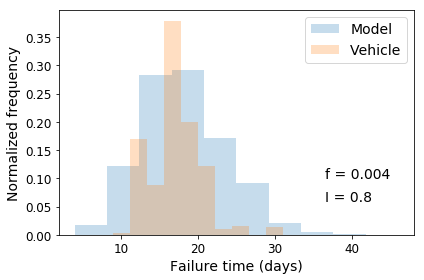

Failure rate, f:
[0.004]
Interdependency, I:
[0.8]


In [13]:
# Plot
#plt.title(fn)
plt.hist(nnlifespans[opt_idx], weights=1/len(nnlifespans[opt_idx])*np.ones(len(nnlifespans[opt_idx])), label='Model', alpha=0.25)
plt.hist(dat_lifespans, weights=1/len(dat_lifespans)*np.ones(len(dat_lifespans)), label='Vehicle', alpha=0.25)
plt.legend(loc='best', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Failure time (days)', fontsize=14)
plt.ylabel('Normalized frequency', fontsize=14)
plt.annotate('f = '+str(round(fitted_f[0],3)),xy=(0.75,0.25),xycoords='axes fraction', fontsize=14)
plt.annotate('I = '+str(round(fitted_I[0],1)),xy=(0.75,0.15),xycoords='axes fraction', fontsize=14)
plt.tight_layout()
plt.savefig('Figures/real_world/fI_hist.png',dpi=800)
plt.show()
    
print ('Failure rate, f:')    
print (fitted_f)
print ('Interdependency, I:')    
print (fitted_I)

### Line search r based on empirical $f$ and $I$ values

#### Run simulations:

In [4]:
run_grid_search([0.004], [0.8], N=200, pop_size=10000, filedir='r_f0.004_I0.8_N200_pop10000', r_list=np.arange(0.04,0.06,0.0005))

#### Fitting for $r$ given $f$ and $I$:

In [15]:
from scipy.stats import ks_2samp

fn = 'alpha_kg_lifespans'
fitdir = 'r_f0.004_I0.8_N200_pop10000'

experiment = 'Alpha-KG'

ps = 10000 # pop_size

fitted_r = []
ks_dist_list = []

for boot in range(100):
    # read and bootstrap data
    df = pd.read_csv('Data/real_world/empirical_mortality_data/Lifespans/'+fn+'.csv')
    dat_lifespans = df[experiment].values
    dat_lifespans = dat_lifespans[np.logical_not(np.isnan(dat_lifespans))]
    dat_lifespans = np.random.choice(dat_lifespans, len(dat_lifespans), replace=True)

    # Read in mortality data for each of the files
    df = pd.read_csv('Data/real_world/empirical_mortality_data/Lifespans/'+fn+'.csv')
    dat_lifespans = df[experiment].values
    dat_lifespans = dat_lifespans[np.logical_not(np.isnan(dat_lifespans))]

    # Run fitting
    ks_dists = []
    p_vals = []
    kl_divs = []
    r_vals = []

    nnlifespans = []
    for fi in os.listdir('Data/real_world/'+fitdir):

        # get parameters
        prm_str = fi.split('r')[1].split('.csv')
        r = float(prm_str[0])

        # get network data
        net_df = pd.read_csv('Data/real_world/'+fitdir+'/'+fi, names=['age', 'deaths', 'mortality'])
        net_ages = net_df['age'].values
        net_deaths = net_df['deaths'].values
        net_lifespans = []
        for idd, net_age in enumerate(net_ages):
            for iddd in range(int(net_deaths[idd])):
                net_lifespans.append(net_age)
        net_lifespans = np.array(net_lifespans)

        # compute KS distance
        D, p = ks_2samp(net_lifespans, dat_lifespans)
        ks_dists.append(D)
        p_vals.append(p)

        # append details
        r_vals.append(r)

        nnlifespans.append(net_lifespans)

    ks_dist_list.append(ks_dists)
    
# Compute average ks_dist
ks_dists = list(np.mean(np.vstack(ks_dist_list),axis=0))

# Get optimal (lowest MSE) fit
opt_idx = ks_dists.index(min(ks_dists))
#opt_idx = p_vals.index(max(p_vals))
fitted_r.append(r_vals[opt_idx])

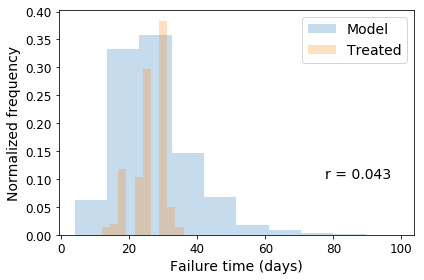

Repair rate, r:
[0.043000000000000003]


In [11]:
# Plot
#plt.title(fn)
plt.hist(nnlifespans[opt_idx], weights=1/len(nnlifespans[opt_idx])*np.ones(len(nnlifespans[opt_idx])), label='Model', alpha=0.25)
plt.hist(dat_lifespans, weights=1/len(dat_lifespans)*np.ones(len(dat_lifespans)), label='Treated', alpha=0.25)
plt.legend(loc='best', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Failure time (days)', fontsize=14)
plt.ylabel('Normalized frequency', fontsize=14)
plt.annotate('r = '+str(round(fitted_r[0],3)),xy=(0.75,0.25),xycoords='axes fraction',fontsize=14)
plt.tight_layout()
plt.savefig('Figures/real_world/r_hist.png',dpi=800)
plt.show()
    
    
print ('Repair rate, r:')    
print (fitted_r)

### Predicted Optimal Controls

For C. elegans alpha-ketogluturate data:
- $f=0.004$
- $I=0.8$
- $r=0.043$

### Figure 3C: Q-learning optimal control applied to C. elegans treatment

In [17]:
a,a1,a2,b,c = plotResultsAVG (directory='Data/real_world/Cluster_alphaketo',
             param='alpha', p_range=np.concatenate((np.linspace(0,7.5,10),np.linspace(7.5,15,10)[1:])), 
             repair_list=[0,0.043], N=200, T=100, plot=False, soln_type='numeric', fine_res=True, binning=False,
                     f=0.004, r=0.043, CI=75, get_CI=True)

C:\Users\edsun\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


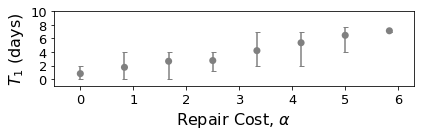

In [18]:
comp_p_range = c
plt.figure(figsize=(6,2))
plt.errorbar(comp_p_range, a, color='0.5', yerr=(np.array(a)-np.array(a1), np.array(a2)-np.array(a)), ecolor='0.5', capsize=2.5, elinewidth=1.5, linewidth=0)
plt.scatter(comp_p_range, a, c='0.5', marker='o', s=50, edgecolors='none', label='Start Repair')
plt.ylabel(r'$T_1$ (days)', fontsize=16)
plt.xlabel(r'Repair Cost, $\alpha$', fontsize=16)
plt.xlim(-0.5,6.3)
plt.xticks(np.arange(0,7,1), fontsize=13)
plt.ylim(-1,10)
plt.yticks(np.arange(0,11,2), fontsize=13)
plt.tight_layout()
plt.savefig('Figures/real_world/Alpha_Keto_RL.png', dpi=800)
plt.show()

A colored background version...

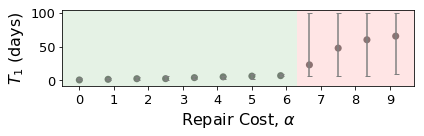

In [9]:
comp_p_range = c
plt.figure(figsize=(6,2))
plt.errorbar(comp_p_range, a, color='0.5', yerr=(np.array(a)-np.array(a1), np.array(a2)-np.array(a)), ecolor='0.5', capsize=2.5, elinewidth=1.5, linewidth=0)
plt.scatter(comp_p_range, a, c='0.5', marker='o', s=50, edgecolors='none', label='Start Repair')
plt.ylabel(r'$T_1$ (days)', fontsize=16)
plt.xlabel(r'Repair Cost, $\alpha$', fontsize=16)
plt.axvspan(6.3, 9.7, facecolor='red', alpha=0.1)
plt.axvspan(-0.5, 6.3, facecolor='green', alpha=0.1)
plt.xlim(-0.5,9.7)
plt.xticks(np.arange(0,10,1), fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.savefig('Figures/real_world/Alpha_Keto_RL.png', dpi=800)
plt.show()